Procediamo con LightGBM + Optuna ottimizzando l’F1-score, che è più adatto per un problema sbilanciato dove minimizzare i falsi negativi è cruciale.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna
import warnings
warnings.filterwarnings("ignore")

# 📦 Carica il dataset
df = pd.read_csv("../data/df_fallrisk_clean.csv")
target_col = "fallers_1_nonfaller_0"

# ❌ Rimuove le feature che causano leakage (derivate direttamente dalle cadute)
leak_vars = [
    "total_falls", "falls_year_rate", "falls_month_rate",
    "cadute_con_frattura", "recurrent_fallers1_nonfallers_occasional0",
    "falls_last_year_1si_2no", "falls_last_year_1si_2no_code"
]
df = df.drop(columns=[col for col in leak_vars if col in df.columns])

# ✅ Definizione X e y
X = df.drop(columns=target_col)
y = df[target_col]

# 🔄 Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🎯 Obiettivo Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("feature_selection", SelectFromModel(model, threshold="median")),
        ("classifier", model)
    ])

    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    return scores.mean()

# 🚀 Ottimizzazione
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 🏆 Parametri ottimali
print("✅ Best Trial:")
print(study.best_trial)

# 📊 Valutazione finale dettagliata
best_params = study.best_trial.params
final_model = RandomForestClassifier(
    **best_params,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", SelectFromModel(final_model, threshold="median")),
    ("classifier", final_model)
])

accs, precs, recs, f1s, rocs = [], [], [], [], []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    rocs.append(roc_auc_score(y_test, y_prob))

print("\n🎯 RISULTATI FINALI 5-FOLD (leakage-free):")
print(f"ACCURACY  : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"PRECISION : {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"RECALL    : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1        : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"ROC_AUC   : {np.mean(rocs):.3f} ± {np.std(rocs):.3f}")

[I 2025-06-11 19:02:34,896] A new study created in memory with name: no-name-d8043b86-8be6-4dd0-99ac-f1468101ee87
[I 2025-06-11 19:02:36,320] Trial 0 finished with value: 0.6495238095238095 and parameters: {'n_estimators': 291, 'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6495238095238095.
[I 2025-06-11 19:02:36,960] Trial 1 finished with value: 0.6904761904761905 and parameters: {'n_estimators': 87, 'max_depth': 10, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.6904761904761905.
[I 2025-06-11 19:02:37,609] Trial 2 finished with value: 0.6628571428571428 and parameters: {'n_estimators': 101, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.6904761904761905.
[I 2025-06-11 19:02:38,216] Trial 3 finished with value: 0.677142857142857 and parameters: {'n_estimators': 112, 'max_depth': 12, 'max_fea

✅ Best Trial:
FrozenTrial(number=42, state=1, values=[0.7323809523809524], datetime_start=datetime.datetime(2025, 6, 11, 19, 2, 56, 605158), datetime_complete=datetime.datetime(2025, 6, 11, 19, 2, 57, 155817), params={'n_estimators': 275, 'max_depth': 13, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None)), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=42, value=None)

🎯 RISULTATI FINALI 5-FOLD (leakage-free):
ACCURACY  : 0.732 ± 0.083
PRECISION : 0.783 ± 0.087
RECALL    : 0.817 ± 0.116
F1        : 0.791 ± 0.059
ROC_AUC   : 0.641 ± 0.226


# Explainability analysis

SHAP shape: (71, 20, 2)
X_selected shape: (71, 20)


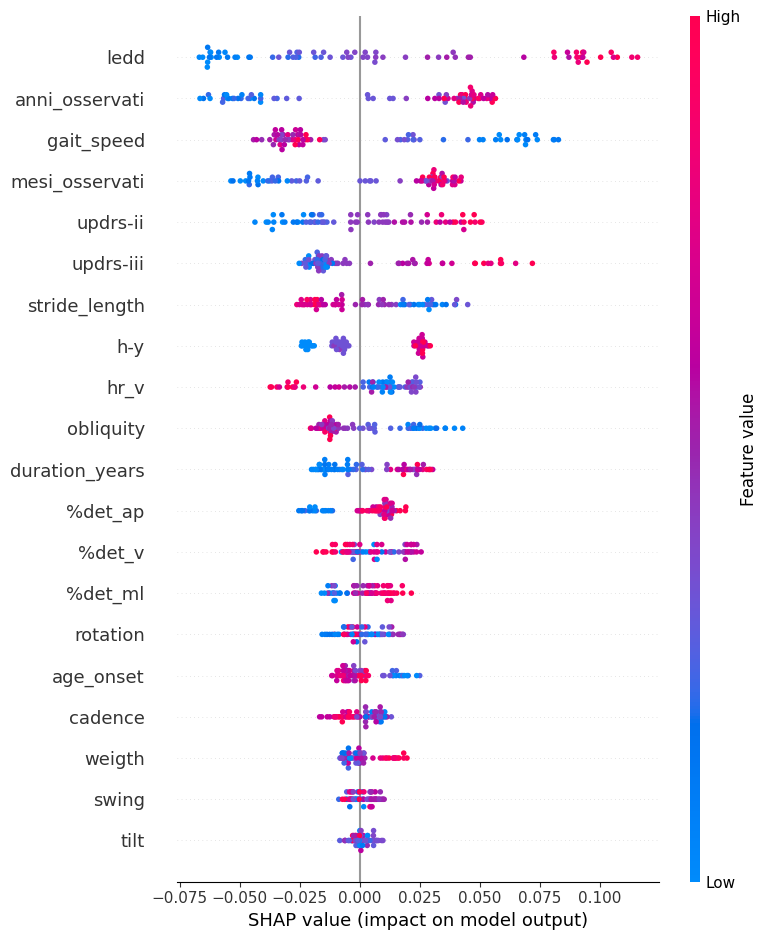

In [6]:
import shap
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel

# Ricalcola le feature selezionate
selector = SelectFromModel(final_model, threshold="median")
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

# Fit finale del modello
final_model.fit(X_selected, y)

# SHAP explainability
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_selected)

# Verifica forma
print("SHAP shape:", np.array(shap_values).shape)
print("X_selected shape:", X_selected.shape)

# Summary plot correttamente indirizzato alla classe positiva
shap.summary_plot(shap_values[:, :, 1], X_selected, feature_names=selected_features)


| Feature                          | Impatto SHAP (💥) | Interpretazione suggerita                                                                                              |
| -------------------------------- | ----------------- | ---------------------------------------------------------------------------------------------------------------------- |
| **LEDD**                         | Alto e coerente   | Dosi elevate (rosa) → associato ad aumento rischio caduta: possibile indicatore di severità o compensazione aggressiva |
| **Anni\_osservati**              | Alto              | Più anni di osservazione = pazienti con storia lunga → più rischio (effetto co-variante cronica)                       |
| **Gait speed**                   | Significativo     | Bassa velocità (blu) → predice più cadute: indicatore classico di fragilità                                            |
| **Mesi\_osservati**              | Simile a anni     | Probabile collinearità, da tenere d'occhio in interpretazione                                                          |
| **UPDRS-II e III**               | Chiaro segnale    | Più severità funzionale e motoria = più rischio cadute                                                                 |
| **Stride\_length**               | Intuitivo         | Passi più corti (blu) → più rischio                                                                                    |
| **H-Y**                          | Leggero impatto   | Più avanzato = più rischio, ma meno discriminante                                                                      |
| **hr\_v / obliquity / %det\_AP** | Non trascurabili  | Parametri biomeccanici interessanti da esplorare nei grafici interazione                                               |

🧠 Insight clinico
La caduta è predetta da un misto di:

severità neurologica (UPDRS, H-Y)
compensazioni farmacologiche (LEDD)
alterazioni biomeccaniche (gait speed, stride, hr_v)
durata della malattia o osservazione
LEDD e UPDRS hanno impatti "positivi": valori alti spingono verso classe faller.
Gait speed, stride length, %det hanno direzione opposta: valori bassi aumentano il rischio.

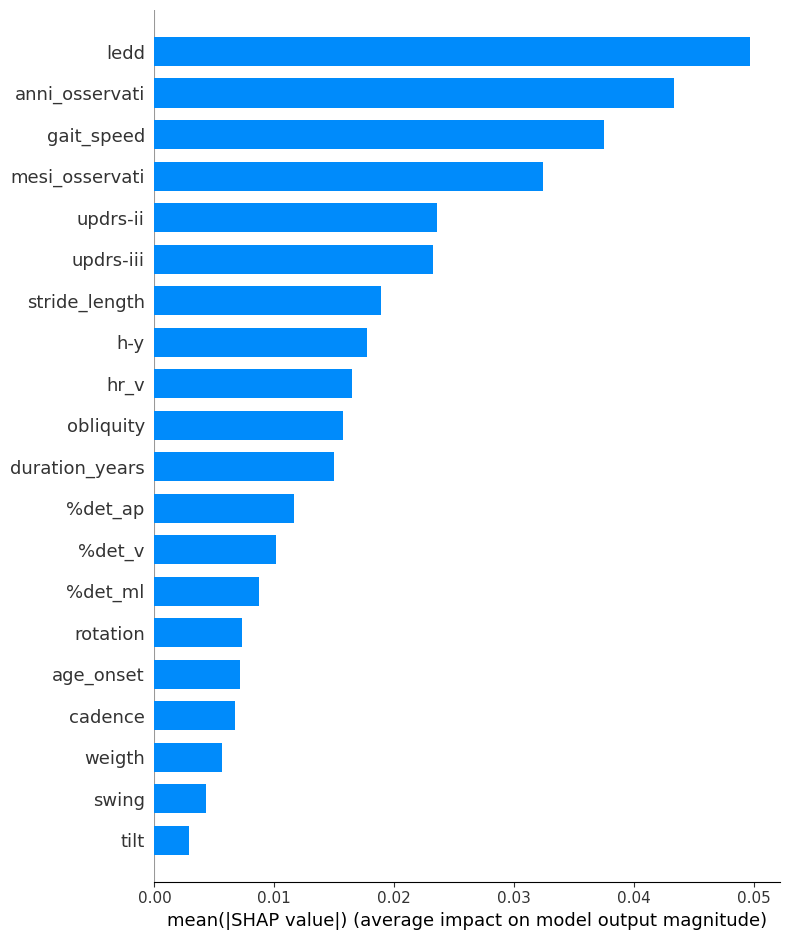

In [7]:
shap.summary_plot(shap_values[:, :, 1], X_selected, feature_names=selected_features, plot_type="bar")

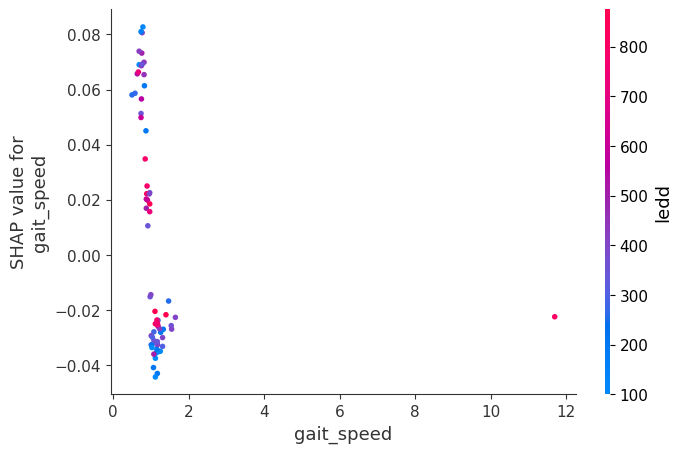

In [8]:
shap.dependence_plot("gait_speed", shap_values[:, :, 1], X_selected, feature_names=selected_features)

In [10]:
import pandas as pd
import numpy as np
import shap

# X = solo le feature selezionate
# y = target
# final_model = random forest finale
# selected_features = colonne selezionate da SelectFromModel
# X_selected = dati su cui il modello è stato addestrato

# Ricalcola SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_selected)
shap_vals_class1 = shap_values[:, :, 1]  # per classe faller

# DataFrame SHAP + feature
shap_df = pd.DataFrame(shap_vals_class1, columns=selected_features)
X_df = pd.DataFrame(X_selected, columns=selected_features)

# Trova osservazioni con impatto SHAP positivo su predizione di caduta
mask_faller = (shap_df.sum(axis=1) > 0)
faller_data = X_df[mask_faller]

# Calcola range, IQR, media
summary = []
for col in selected_features:
    vals = faller_data[col]
    summary.append({
        "feature": col,
        "min": np.round(vals.min(), 3),
        "Q1": np.round(vals.quantile(0.25), 3),
        "median": np.round(vals.median(), 3),
        "Q3": np.round(vals.quantile(0.75), 3),
        "max": np.round(vals.max(), 3)
    })


df_ranges = pd.DataFrame(summary)
df_ranges.head(10)

,feature,min,Q1,median,Q3,max
0,hr_v,1.290,1.693,1.879,2.156,2.838
1,%det_v,11.681,59.653,69.499,79.624,96.424
2,%det_ml,4.526,53.825,71.841,85.116,98.523
3,%det_ap,8.000,50.428,69.205,87.203,98.431
4,weigth,55.000,68.000,75.000,85.000,100.000
5,age_onset,36.000,58.000,65.000,70.000,83.000
6,duration_years,0.500,4.000,8.000,11.000,26.000
7,ledd,100.000,352.000,460.000,730.000,1227.000
8,updrs-ii,7.000,12.000,15.000,23.000,34.000
9,updrs-iii,3.000,14.000,19.000,23.000,36.000


In [11]:
import pandas as pd
import os

# Definisci i dati
data = {
    "feature": ["hr_v", "%det_v", "%det_ml", "%det_ap", "weigth", "age_onset", "duration_years", "ledd", "updrs-ii", "updrs-iii"],
    "min": [1.290, 11.681, 4.526, 8.000, 55.000, 36.000, 0.500, 100.000, 7.000, 3.000],
    "Q1": [1.693, 59.653, 53.825, 50.428, 68.000, 58.000, 4.000, 352.000, 12.000, 14.000],
    "median": [1.879, 69.499, 71.841, 69.205, 75.000, 65.000, 8.000, 460.000, 15.000, 19.000],
    "Q3": [2.156, 79.624, 85.116, 87.203, 85.000, 70.000, 11.000, 730.000, 23.000, 23.000],
    "max": [2.838, 96.424, 98.523, 98.431, 100.000, 83.000, 26.000, 1227.000, 34.000, 36.000]
}

# Crea il DataFrame
df_ranges = pd.DataFrame(data)

# Definisci il percorso di salvataggio
output_dir = "results/tables"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "ranges_fallers.csv")

# Salva il file CSV
df_ranges.to_csv(output_path, index=False)

print(f"✅ Tabella salvata in: {output_path}")

✅ Tabella salvata in: results/tables/ranges_fallers.csv


# Salviamo la Pipeline Finale

In [18]:
import joblib
joblib.dump(pipeline, "../backend/fallrisk_api/fallrisk_pipeline.pkl")


['../backend/fallrisk_api/fallrisk_pipeline.pkl']

In [19]:
pipeline = joblib.load("../backend/fallrisk_api/fallrisk_pipeline.pkl")

In [20]:
from sklearn.feature_selection import SelectFromModel
import joblib

# Carica il pipeline e il dataset
pipeline = joblib.load("../backend/fallrisk_api/fallrisk_pipeline.pkl")
df = pd.read_csv("../data/df_fallrisk_clean.csv")

# Rimuovi target e leak features
leak_vars = [
    "total_falls", "falls_year_rate", "falls_month_rate",
    "cadute_con_frattura", "recurrent_fallers1_nonfallers_occasional0",
    "falls_last_year_1si_2no", "falls_last_year_1si_2no_code"
]
df = df.drop(columns=[col for col in leak_vars if col in df.columns])
X = df.drop(columns="fallers_1_nonfaller_0")

# Estrai le feature selezionate
selector = pipeline.named_steps["feature_selection"]
selected_features = X.columns[selector.get_support()].tolist()

print("📌 Feature da usare nella webapp:")
print(selected_features)

📌 Feature da usare nella webapp:
['hr_v', '%det_v', '%det_ml', '%det_ap', 'weigth', 'age_onset', 'duration_years', 'ledd', 'updrs-ii', 'updrs-iii', 'h-y', 'tilt', 'obliquity', 'rotation', 'stance', 'stride_length', 'cadence', 'gait_speed', 'mesi_osservati', 'anni_osservati']


In [21]:
# STEP 1: Scegli le 10 feature finali per la webapp
webapp_features = ['hr_v', '%det_v', '%det_ml', '%det_ap', 'weigth', 'age_onset',
                   'duration_years', 'ledd', 'updrs-ii', 'updrs-iii']

# STEP 2: Riduci il dataset a queste feature + target
X_webapp = df[webapp_features]
y_webapp = df["fallers_1_nonfaller_0"]

# STEP 3: Ricrea una pipeline minimale (es. scaler + modello)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

simple_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

# STEP 4: Allena il modello
simple_pipeline.fit(X_webapp, y_webapp)

# STEP 5: Salva la nuova pipeline
joblib.dump(simple_pipeline, "../backend/fallrisk_api/fallrisk_pipeline.pkl")

print("✅ Nuova pipeline salvata con solo le 10 feature")

✅ Nuova pipeline salvata con solo le 10 feature


In [23]:
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# STEP 1: Carica il dataset
df = pd.read_csv("../data/df_fallrisk_clean.csv")

# STEP 2: Rimuovi target e variabili leak
leak_vars = [
    "total_falls", "falls_year_rate", "falls_month_rate",
    "cadute_con_frattura", "recurrent_fallers1_nonfallers_occasional0",
    "falls_last_year_1si_2no", "falls_last_year_1si_2no_code"
]
df = df.drop(columns=[col for col in leak_vars if col in df.columns])

# STEP 3: Definisci le feature da usare nella webapp
webapp_features = ['hr_v', '%det_v', '%det_ml', '%det_ap', 'weigth',
                   'age_onset', 'duration_years', 'ledd', 'updrs-ii', 'updrs-iii']

# STEP 4: Seleziona X e y
X_webapp = df[webapp_features]
y_webapp = df["fallers_1_nonfaller_0"]

# STEP 5: Crea una nuova pipeline minimalista
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

# STEP 6: Allena il modello
pipeline.fit(X_webapp, y_webapp)

# STEP 7: Salva il modello in formato .pkl
joblib.dump(pipeline, "../backend/fallrisk_api/fallrisk_pipeline.pkl")

print("✅ Pipeline minimale salvata correttamente!")

✅ Pipeline minimale salvata correttamente!
